In [1]:

import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import pandas as pd
import copy
%matplotlib inline

try:
    import cPickle as pickle
except ImportError:
    import pickle
import scipy
from scipy import interpolate
from scipy.interpolate import interp2d, NearestNDInterpolator,LinearNDInterpolator

In [3]:
def WeightAtEachPt(Flux,Tau,NumLaunched,Weight):
    InjectArea=np.pi*100**2 #cm
    Tau_sec=Tau*24*60*60 #take from days to seconds
    W= Flux*Tau_sec*InjectArea*(2*NumLaunched/(4*np.pi*.6))**-1*Weight*2
    return W

In [4]:
def Ry (R, phi, theta):
    return (R) * np.cos(phi)

def Rx (R, phi, theta):
    return (R) * np.sin(phi) * np.cos(theta)

def Rz (R, phi, theta):
    return (R) * np.sin(phi) * np.sin(theta)

In [5]:
#In these files the things previously called "bs" were actually gammas. 
# Switch to this naming.

f=open("./MCEqFluxMeshes.pkl","rb")
EBins, cosas, gs, FluxMeshes= pickle.load(f)
f.close()

f=open("./MCEqFluxMeshes_Zat.pkl","rb")
EBinsZ, cosasZ, gsZ,FluxMeshesZat= pickle.load(f)
f.close()   

f=open("./MCEqFluxMeshes_Epos.pkl","rb")
EBinsE, cosasE, gsE,FluxMeshesEpos= pickle.load(f)
f.close()   

f=open("./LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()



In [168]:
#In this file, beta is also in detector coords. Beta is measured anticlockwise from detector X in radians.
# We will also need gamma for calling fluxes. Gamma is measured anticlockwise from East in degrees.
# We assume lab North is 40 degrees off -X; ie beta and gamma are same sign and separared by 50.

RelativeAngle=50

MCmus=pd.read_hdf("./MCmuonsSelectedSmallerSphere.h5",key="muons")
MCmus.loc[(MCmus.muenergy>2)&(MCmus.perconline>.79)&(MCmus.linelength>73.5)&(MCmus.dEdx<.015),'passed']=True

MCmus['gamma']=(np.rad2deg(MCmus['beta'])-RelativeAngle)%360
MCmus['MCgamma']=(np.rad2deg(MCmus['MCbeta'])-RelativeAngle)%360

NumLaunched=len(MCmus.run.unique())*300




In [190]:
#Same conventions as above
MuonsFromData=pd.read_hdf('./CombinedDataMusRunV.h5')
MuonsFromData['gamma']=(np.rad2deg(MuonsFromData['beta'])-RelativeAngle)%360

#This is the spark cut in detector coordinates
MuonsNoSparks=MuonsFromData[(MuonsFromData.zvariance>4)&(np.abs(MuonsFromData.beta-180)>4)]



Text(0.5, 1.0, 'Totally unprocessed raw data')

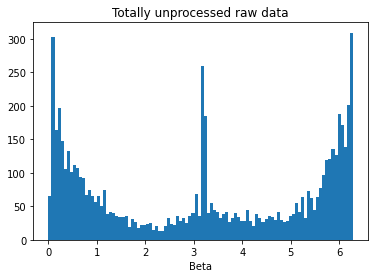

In [250]:
#Look at the raw data
plt.hist(MuonsFromData['beta'],bins=100)
plt.xlabel("Beta")
plt.title("Totally unprocessed raw data")

In [191]:
#Leslies stuff - (Leslies comment: this is wrong wtf was i doing)
eps=0.01
survivalfractions=[]
correctedmeshes=[]

survivalfractionsZat=[]
correctedmeshesZat=[]

survivalfractionsEPOS=[]
correctedmeshesEPOS=[]

for ei in range(0,len(EBins)-2):
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    for ica in range(len(cosas)):
        for ig in range(len(gs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,gs[ig])
            survmesh[ica,ig]=surv
            mesh[ica,ig]=mesh[ica,ig]*surv
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)
    
for ei in range(0,len(EBinsZ)-2):

    meshZat=copy.copy(FluxMeshesZat[ei])  
    survmeshZat=np.zeros_like(meshZat)
    
    for ica in range(len(cosasZ)):
        for ig in range(len(gsZ)):
            surv=LinInterps[EBinsZ[ei]](cosasZ[ica]+eps,gsZ[ig])                
            survmeshZat[ica,ig]=surv
            meshZat[ica,ig]=meshZat[ica,ig]*surv


    correctedmeshesZat.append(meshZat)
    survivalfractionsZat.append(survmeshZat)

    
for ei in range(0,len(EBinsE)-2):

    meshEPOS=copy.copy(FluxMeshesEpos[ei])  
    survmeshEpos=np.zeros_like(meshEPOS)
    
    for ica in range(len(cosasE)):
        for ig in range(len(gsE)):
            surv=LinInterps[EBinsE[ei]](cosasE[ica]+eps,gsE[ig])                

            survmeshEpos[ica,ig]=surv
            
            meshEPOS[ica,ig]=meshEPOS[ica,ig]*surv


    correctedmeshesEPOS.append(meshEPOS)
    survivalfractionsEPOS.append(survmeshEpos)

Text(0, 0.5, '$\\gamma$')

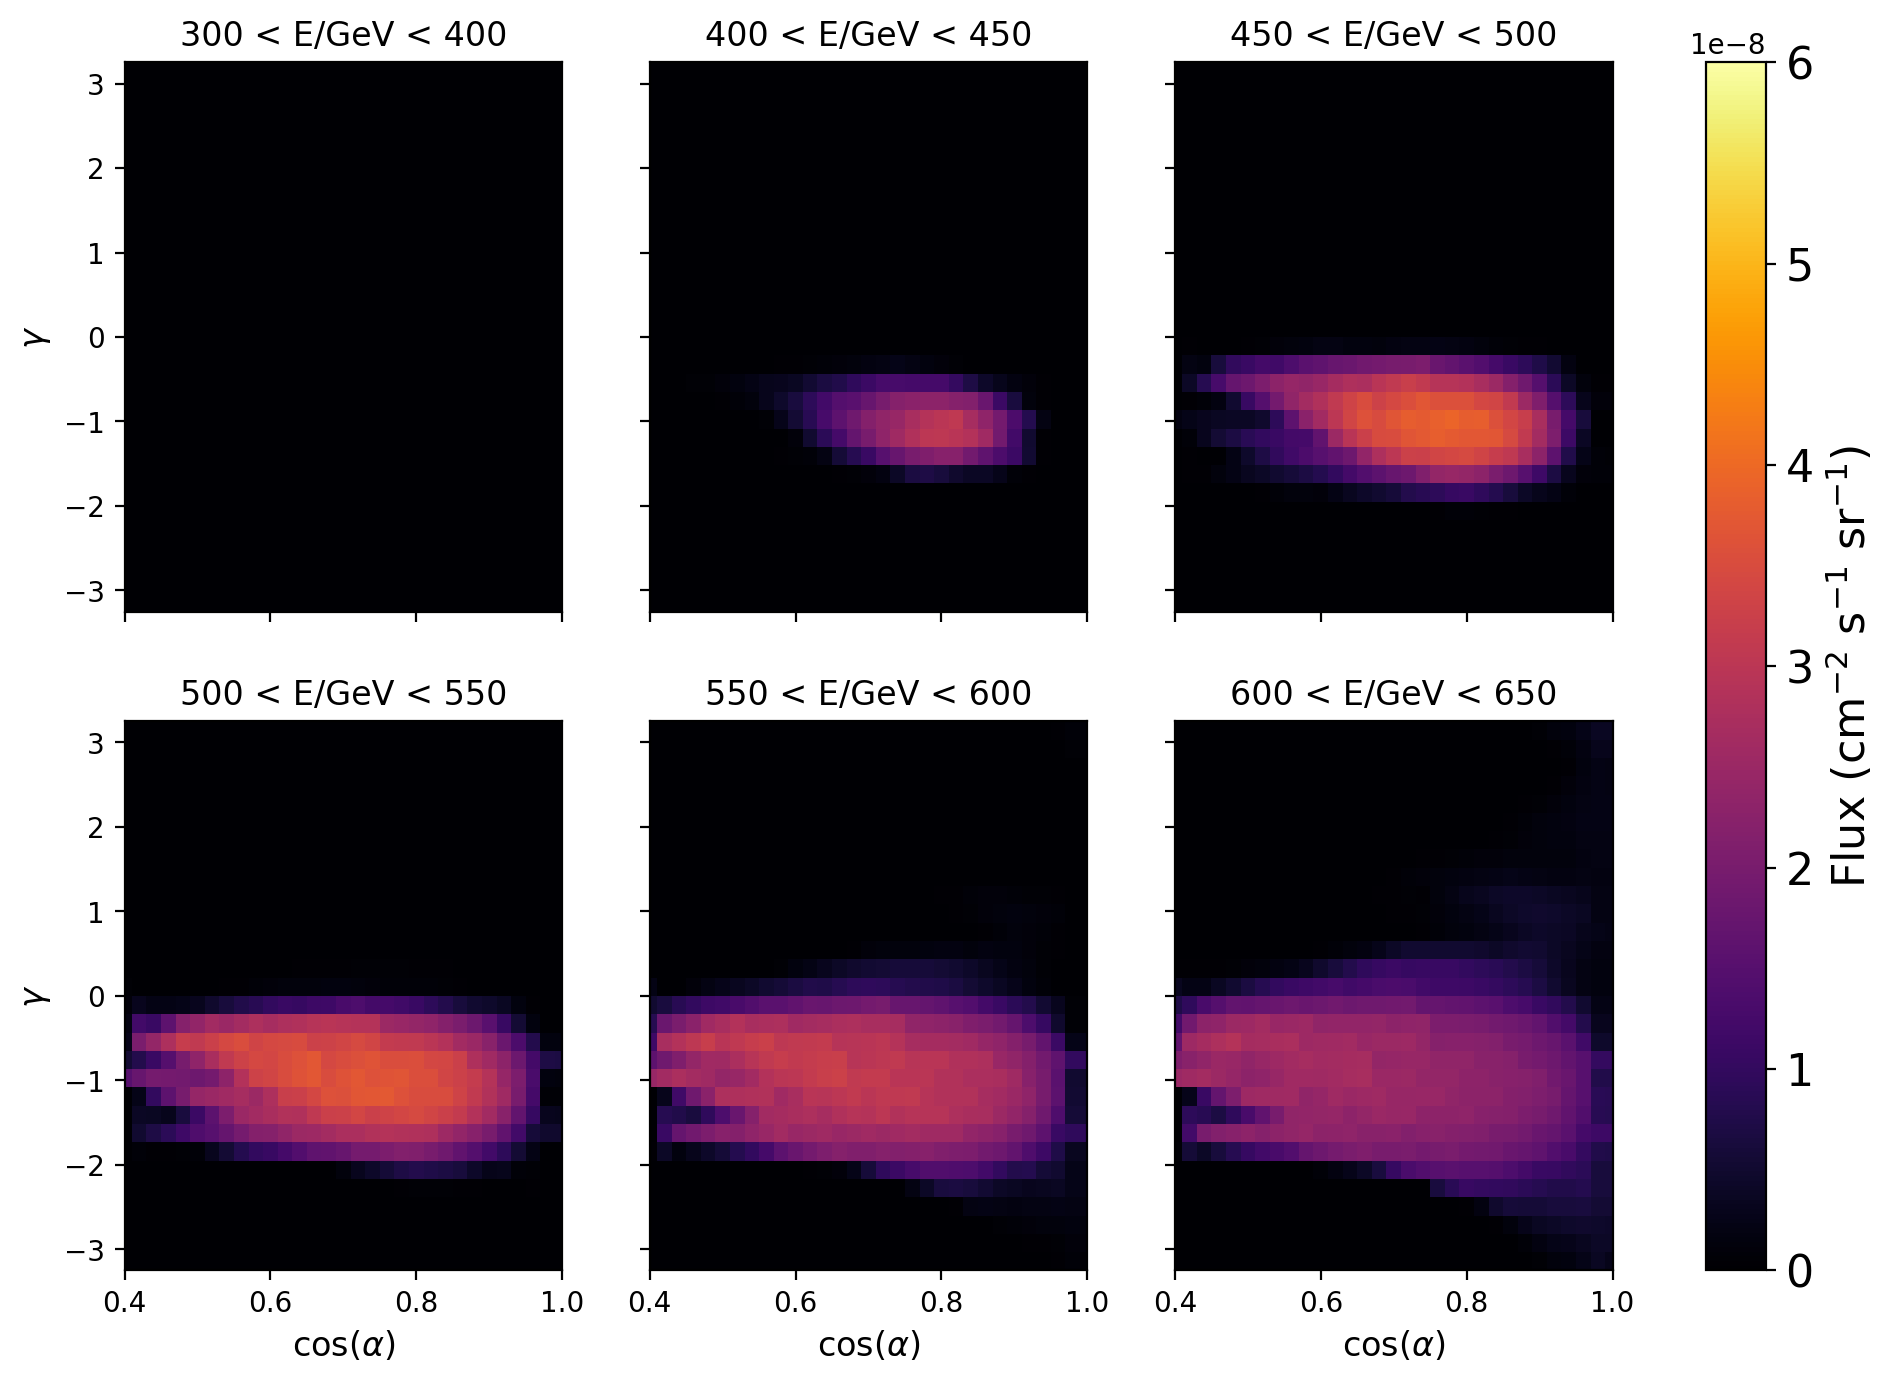

In [192]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,gs,np.transpose(correctedmeshes[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=6e-8)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\gamma$",fontsize=12)
axes[0,0].set_ylabel(r"$\gamma$",fontsize=12)

Text(0, 0.5, '$\\gamma$')

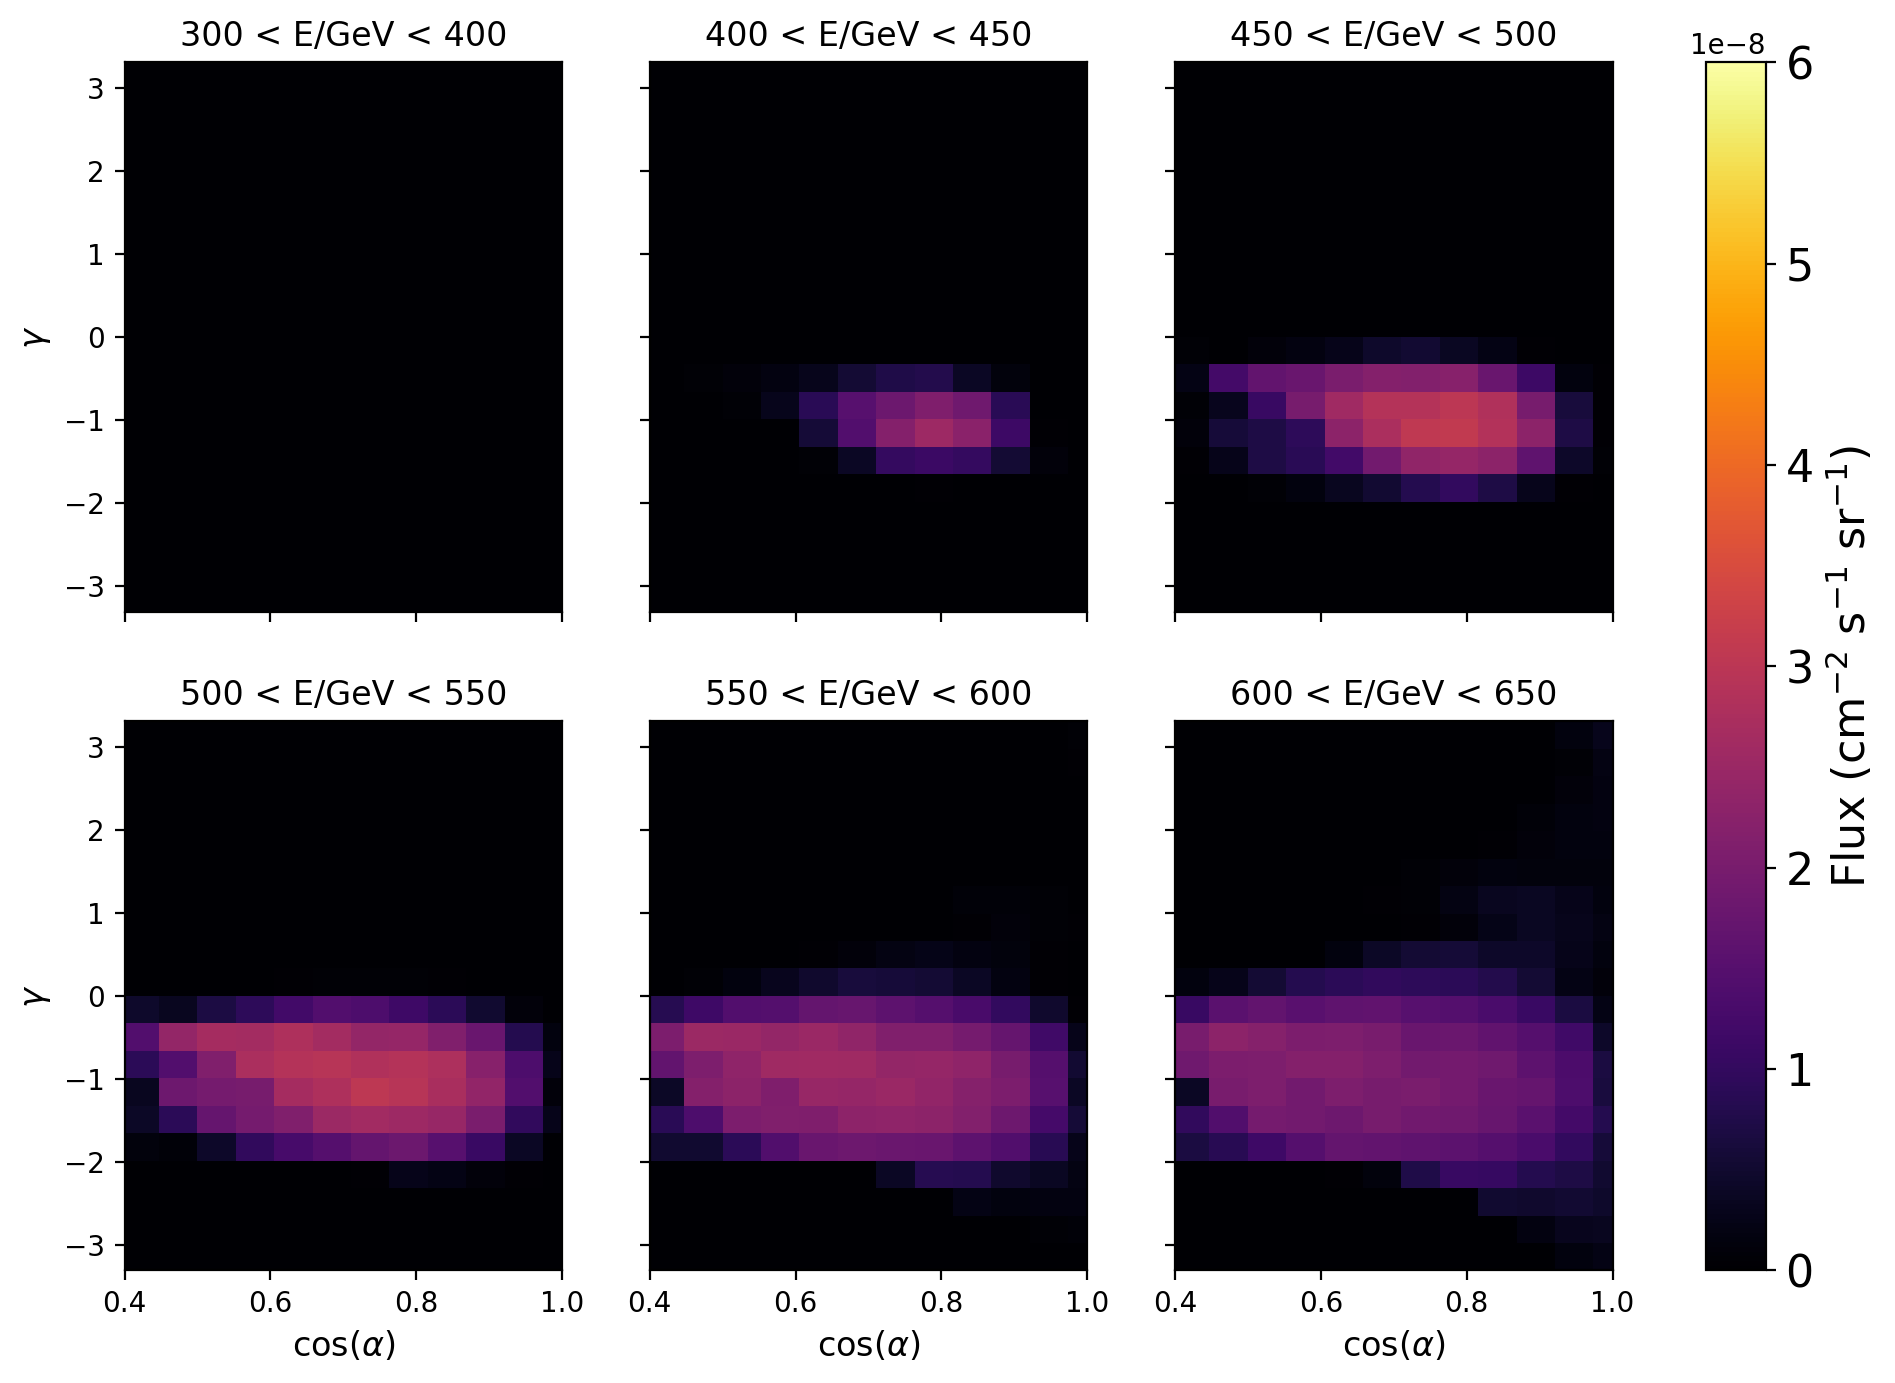

In [193]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosasZ,gsZ,np.transpose(correctedmeshesZat[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=6e-8)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\gamma$",fontsize=12)
axes[0,0].set_ylabel(r"$\gamma$",fontsize=12)

Text(0, 0.5, '$\\gamma$')

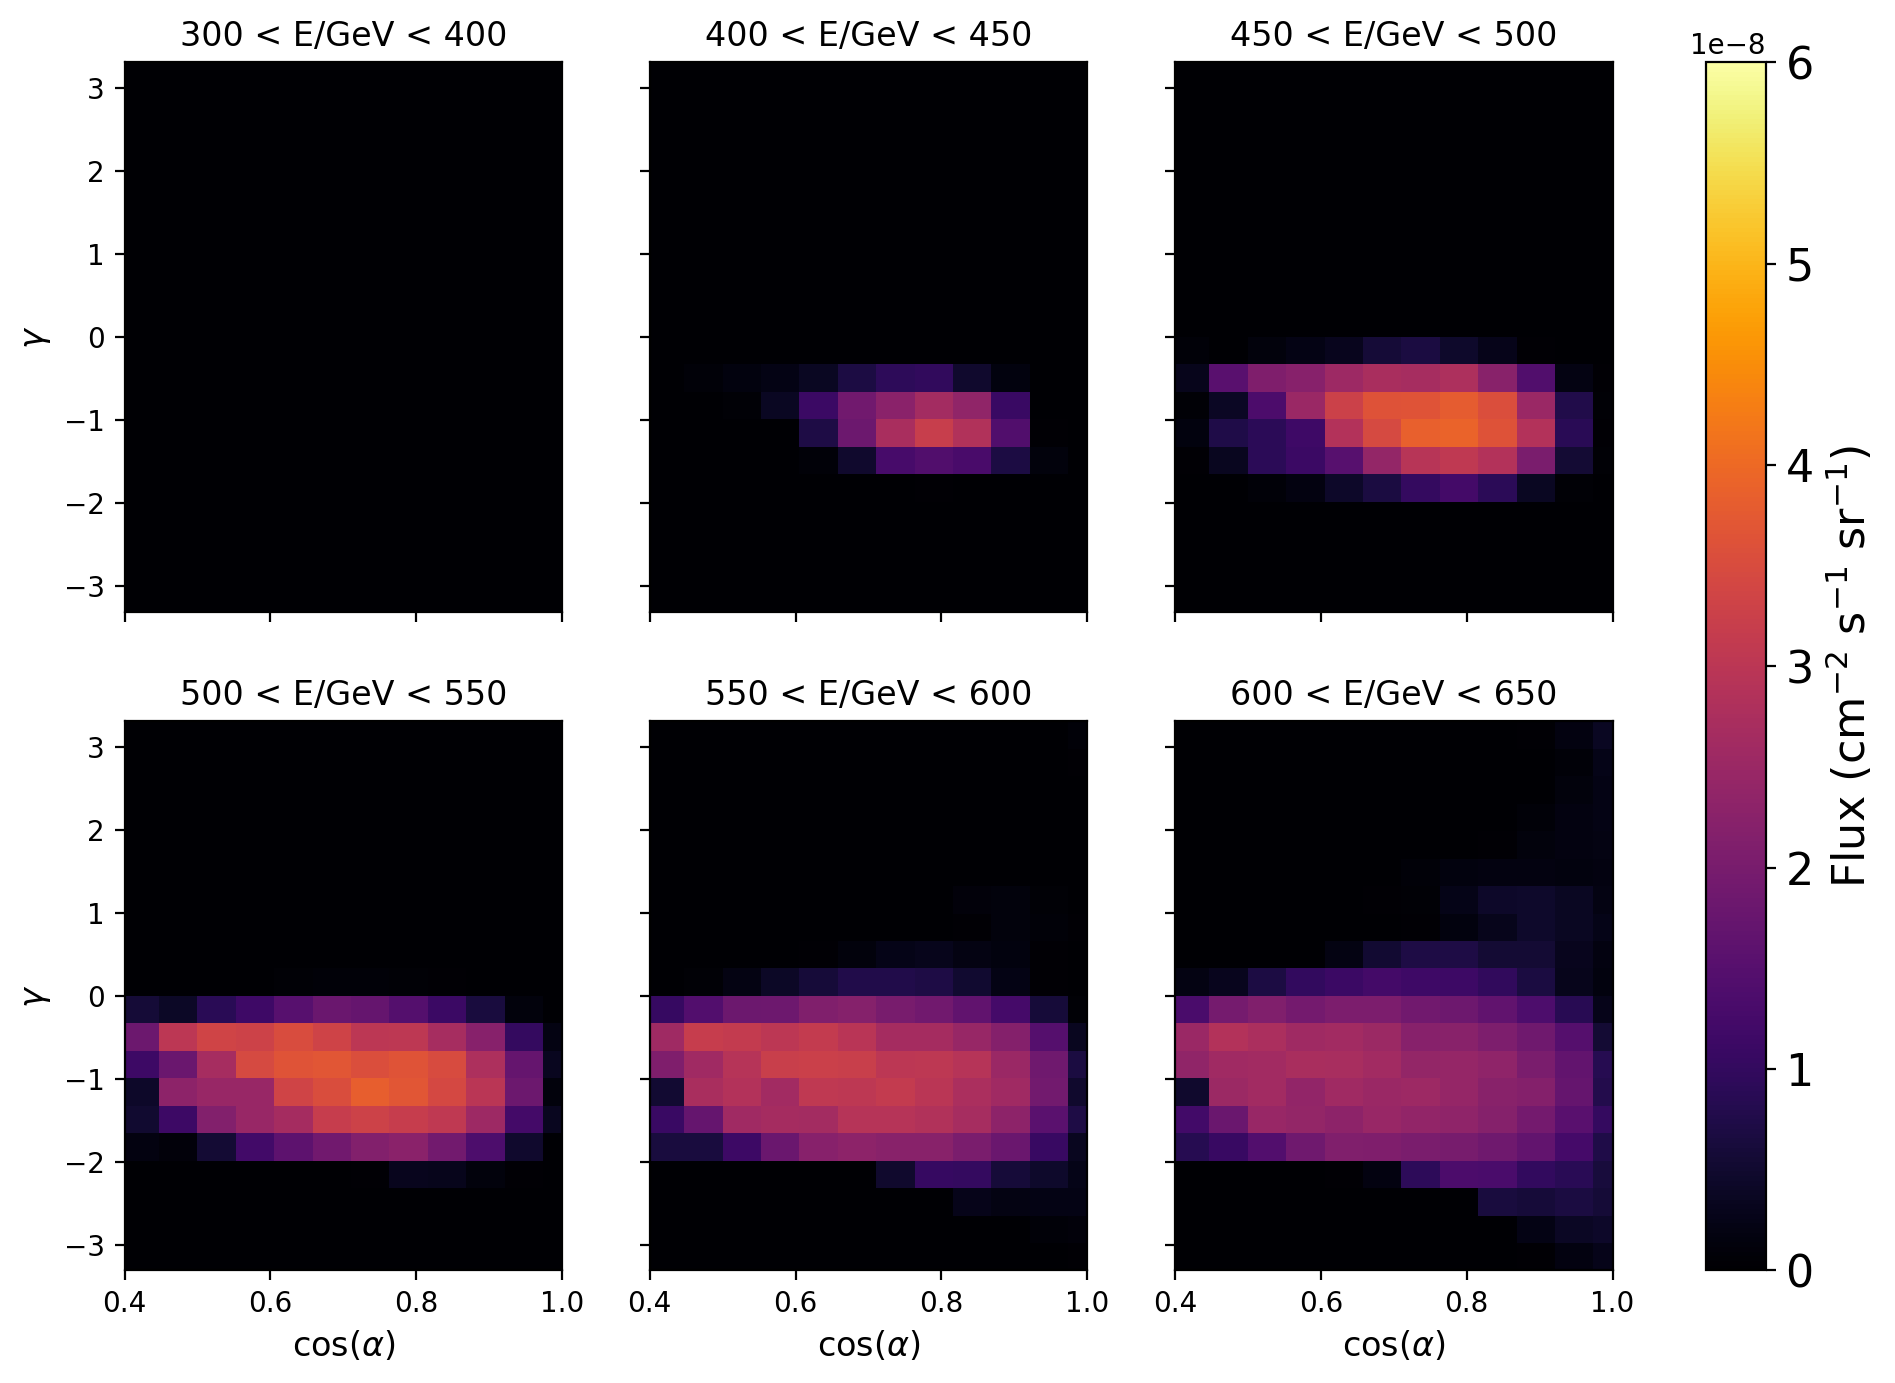

In [194]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosasE,gsE,np.transpose(correctedmeshesEPOS[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=6e-8)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\gamma$",fontsize=12)
axes[0,0].set_ylabel(r"$\gamma$",fontsize=12)

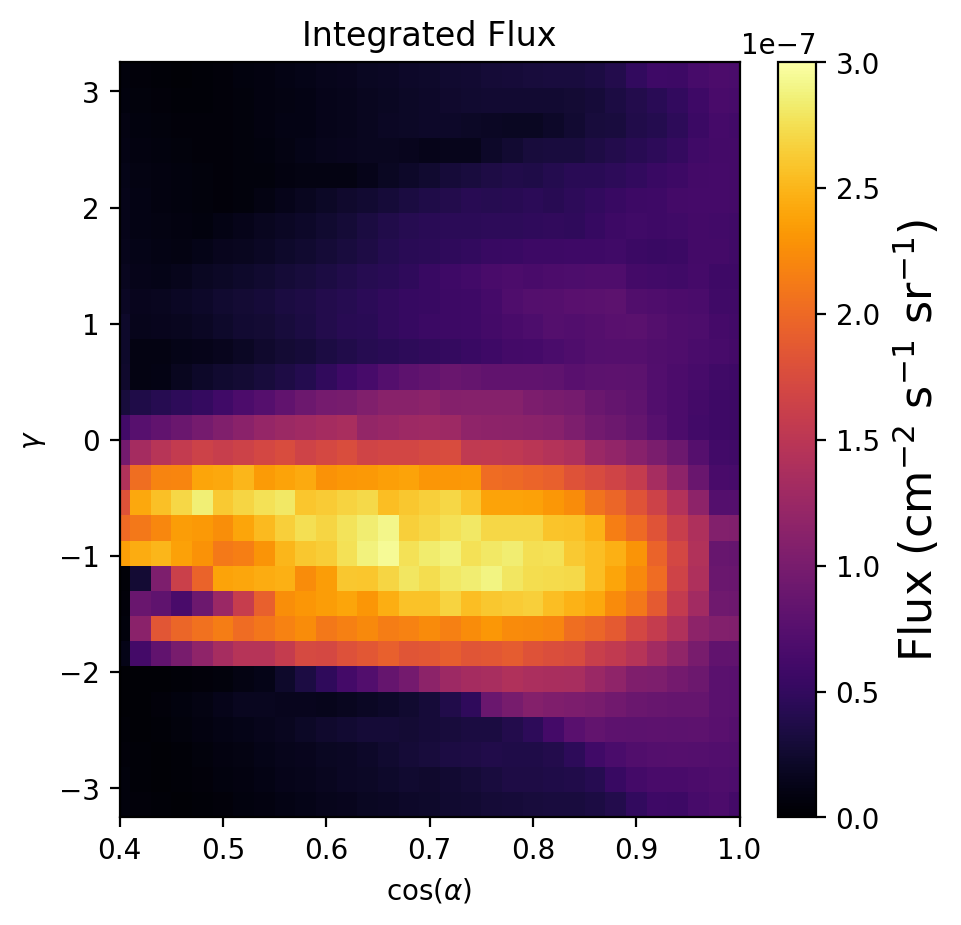

In [195]:
totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m


plt.figure(figsize=(5,5),dpi=200)
im=plt.pcolormesh(cosas,gs,np.transpose(totalflux),cmap='inferno',shading='auto',vmin=0,vmax=3e-7)
ax.set_title("Integrated")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\gamma$")
plt.xlim(0.4,1)
plt.title("Integrated Flux")
cbar=plt.colorbar()
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)



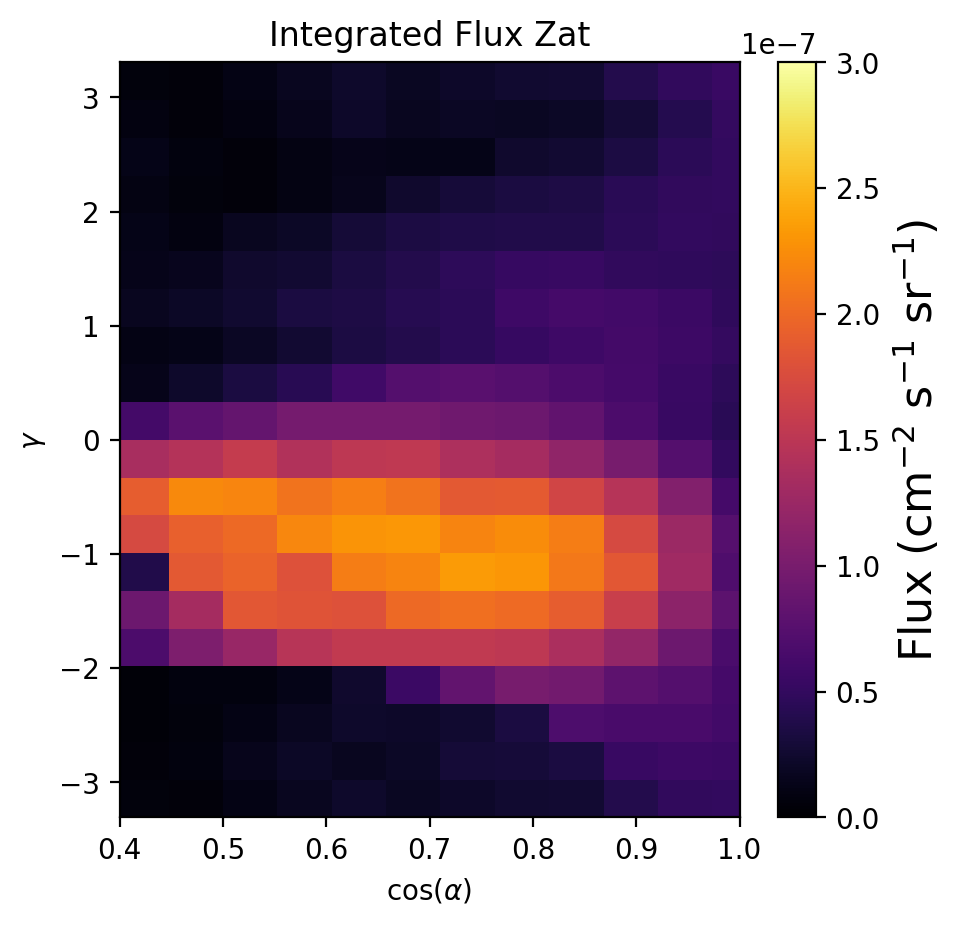

In [196]:
totalfluxZat=np.zeros_like(correctedmeshesZat[0])
for n in  correctedmeshesZat:
    totalfluxZat+=n

plt.figure(figsize=(5,5),dpi=200)
im=plt.pcolormesh(cosasZ,gsZ,np.transpose(totalfluxZat),cmap='inferno',shading='auto',vmin=0,vmax=3e-7)
ax.set_title("Integrated")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\gamma$")
plt.xlim(0.4,1)
plt.title("Integrated Flux Zat")
cbar=plt.colorbar()
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)



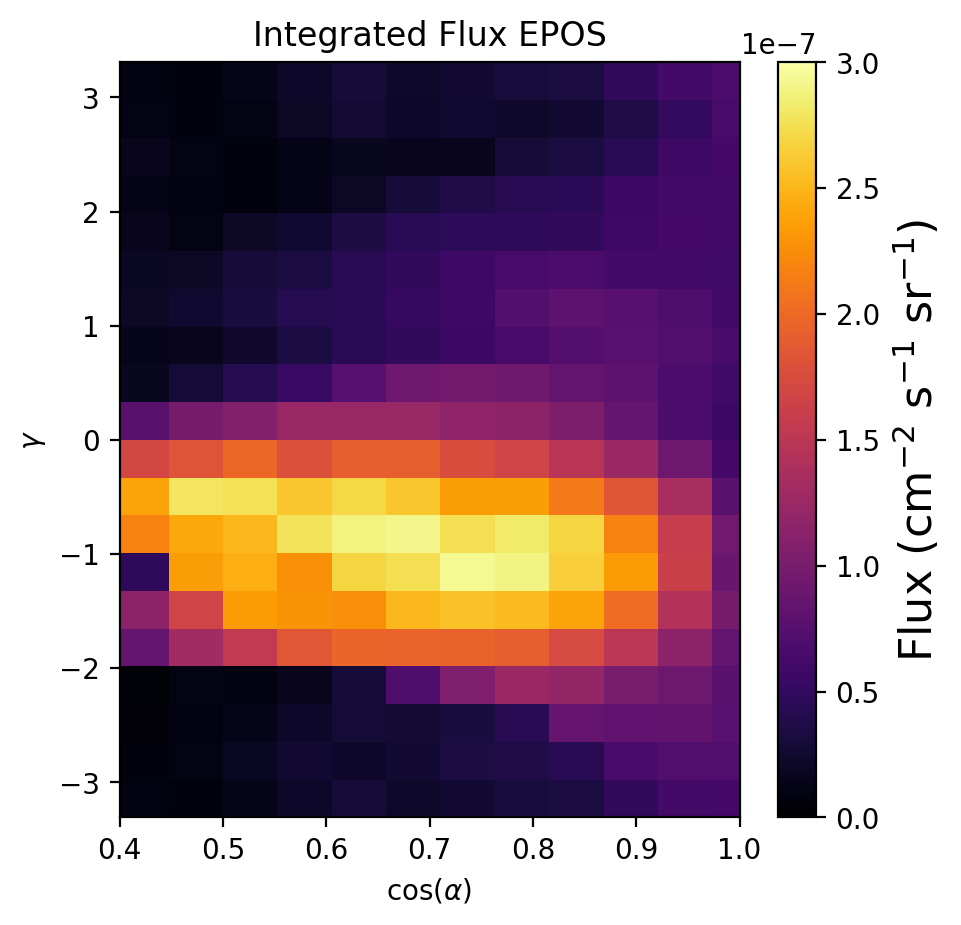

In [197]:
totalfluxEPOS=np.zeros_like(correctedmeshesEPOS[0])
for n in  correctedmeshesEPOS:
    totalfluxEPOS+=n

plt.figure(figsize=(5,5),dpi=200)
im=plt.pcolormesh(cosasE,gsE,np.transpose(totalfluxEPOS),cmap='inferno',shading='auto',vmin=0,vmax=3e-7)
ax.set_title("Integrated")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\gamma$")
plt.xlim(0.4,1)
plt.title("Integrated Flux EPOS")
cbar=plt.colorbar()
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)

In [198]:
totalfluxZat=np.nan_to_num(totalfluxZat,nan=0)
totalfluxEPOS=np.nan_to_num(totalfluxEPOS,nan=0)

totalfluxZat=np.nan_to_num(totalfluxZat,nan=0)
totalfluxEPOS=np.nan_to_num(totalfluxEPOS,nan=0)

#These flux interpolation functions work best if we standardize to
#  accepting gamma in degrees 0<g<360

def ToDegrees(x):
    return (x*180/np.pi)%360

gs_g,cosas_g=np.meshgrid(ToDegrees(gs),cosas)
FluxMuons=scipy.interpolate.NearestNDInterpolator(np.transpose([cosas_g.flatten(),gs_g.flatten()]),totalflux.flatten()) 

gsZ_g,cosasZ_g=np.meshgrid(ToDegrees(gsZ),cosasZ)
FluxMuonsZat=scipy.interpolate.NearestNDInterpolator(np.transpose([cosasZ_g.flatten(),gsZ_g.flatten()]),totalfluxZat.flatten()) 

gsE_g,cosasE_g=np.meshgrid(ToDegrees(gsE),cosasE)    
FluxMuonsEPOS=scipy.interpolate.NearestNDInterpolator(np.transpose([cosasE_g.flatten(),gsE_g.flatten()]),totalfluxEPOS.flatten()) 


    

In [271]:
#For some reason this is measured counterclockwise from West
f=open("./MeasuredPolarFluxInterpolator_MeasAntiFromWest2.pkl","rb")
MeasPolarFlux_FromWest= pickle.load(f) 
f.close()

#Put it into normal flux convention
def MeasPolarFlux(cosalpha,gamma):
    gamnew=((180+gamma)%360)*np.pi/180
    alphnew=np.arccos(cosalpha)
    F=MeasPolarFlux_FromWest(gamnew,alphnew )
    return F
    

In [272]:
PassedMC=MCmus[MCmus.passed==True]
radius=1000

W=[]
for LOC in range(0,len(PassedMC)):
    alpha=PassedMC['MCalpha'].iloc[LOC]
    beta=PassedMC['MCbeta'].iloc[LOC] 
    
    xintercept=PassedMC.xintercept.iloc[LOC] 
    yintercept=PassedMC.yintercept.iloc[LOC] 
    zintercept=PassedMC.zintercept.iloc[LOC] 
    
    MCunix=(Rx(radius,alpha,beta))/radius #should be direction of muon
    MCuniy=(Ry(radius,alpha,beta))/radius
    MCuniz=(Rz(radius,alpha,beta))/radius
    
    
    C2=MCunix**2+MCuniy**2+MCuniz**2
    C1=2*(MCunix*xintercept+MCuniy*yintercept+MCuniz*(zintercept-250))
    C0=xintercept**2+yintercept**2 +(zintercept-250)**2-1000**2
         
    t=np.roots([C2,C1,C0])[0]

    
    ptofinterx=MCunix*t+xintercept
    ptofintery=MCuniy*t+yintercept
    ptofinterz=MCuniz*t+zintercept
    
    sphrad=(ptofinterx**2+ptofintery**2+ptofinterz**2)**.5
    sphunix=(ptofinterx)/sphrad
    sphuniy=(ptofintery)/sphrad
    sphuniz=(ptofinterz)/sphrad
    
    PassedMC['Weight'].iloc[LOC]=np.abs(4*(sphunix*MCunix+sphuniy*MCuniy+sphuniz*MCuniz))


PassedMC["WeightedPts"]=0
PassedMC["WeightedPtsEpos"]=0
PassedMC["WeightedPtsZat"]=0
PassedMC["WeightedPts_MeasFlux"]=0
PassedMC["measfluxweight"]=0
PassedMC["simfluxweight_zat"]=0 
PassedMC["simfluxweight_epos"]=0   
PassedMC["simfluxweight"]=0   
        
for loc in range(0,len(PassedMC)):
    MCpt=PassedMC.iloc[loc]
    WT=MCpt.Weight
    F=MeasPolarFlux(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    #print(F)
    PassedMC["measfluxweight"].iloc[loc]=F
    PassedMC["WeightedPts_MeasFlux"].iloc[loc]=WeightAtEachPt(F,271.6,NumLaunched,WT)

    F=FluxMuons(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    #print(np.cos(MCpt.MCalpha),MCpt.MCbeta_rot,F)
    PassedMC["simfluxweight"].iloc[loc]=F
    PassedMC["WeightedPts"].iloc[loc]=WeightAtEachPt(F,271.6,NumLaunched,WT)


    Fz=FluxMuonsZat(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    PassedMC["simfluxweight_zat"].iloc[loc]=Fz
    PassedMC["WeightedPtsZat"].iloc[loc]=WeightAtEachPt(Fz,271.6,NumLaunched,WT)    


    Fe=FluxMuonsEPOS(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    PassedMC["simfluxweight_epos"].iloc[loc]=Fe
    PassedMC["WeightedPtsEpos"].iloc[loc]=WeightAtEachPt(Fe,271.6,NumLaunched,WT)    
        
    #print(F,Fz,Fe)
MCmusSpkCut=PassedMC[(PassedMC.zvariance>4)&(np.abs(np.rad2deg(PassedMC.beta)-180)>4)]



/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-272-6ad3a139ff3f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PassedMC['Weight'].iloc[LOC]=np.abs(4*(sphunix*MCunix+sphuniy*MCuniy+sphuniz*MCuniz))
<ipython-input-272-6ad3a139ff3f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [273]:
MCmusSave=MCmusSpkCut.drop(['Passed'],axis=1)
MCmusSave=MCmusSave.rename(columns={'Weight':'AngleWeight',"WeightedPts":"TotalWeight_Sim"})
#MCmusSave=MCmusSave.rename(columns={"WeightedPts_MeasFlux":"TotalWeight_Meas","measfluxweight":"FluxWeight_Meas"})
MCmusSave.to_hdf('./MCmusPassedWithSparkCut2.h5','Muons')

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['xintercept', 'yintercept', 'zintercept', 'AngleWeight', 'run'], dtype='object')]

  pytables.to_hdf(


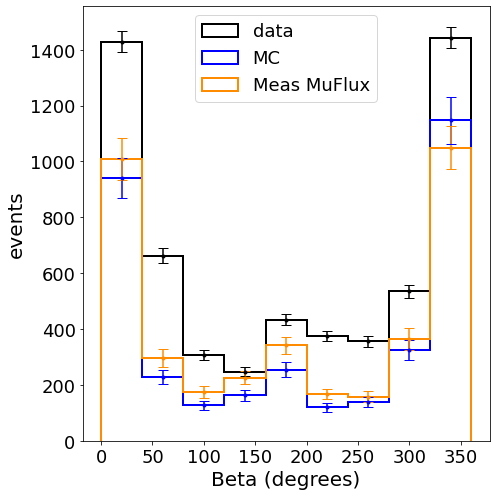

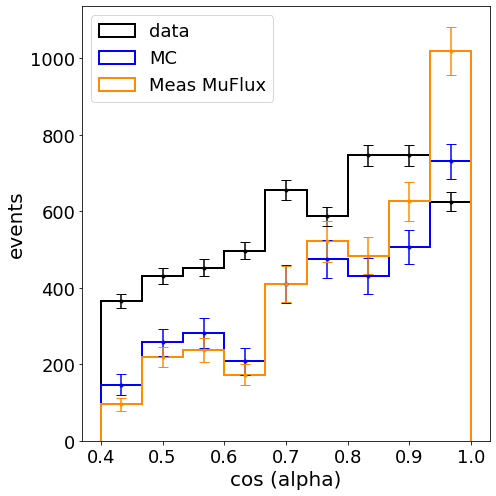

In [274]:
numofsteps=10

plt.figure(figsize=(7,7))
h=plt.hist(MuonsNoSparks['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')



MCwt=(MCmusSpkCut['WeightedPts']+MCmusSpkCut['WeightedPtsZat']+MCmusSpkCut['WeightedPtsEpos'])/3
ST5=np.sum(MCmusSpkCut['WeightedPts']**2)
SB5=np.sum(MCmusSpkCut['WeightedPtsZat']**2)
SE5=np.sum(MCmusSpkCut['WeightedPtsEpos']**2)


err5=((ST5+SB5+SE5)/3)**.5





Mh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(0,360,numofsteps),color='Blue',label='MC',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=MCmusSpkCut['WeightedPts']**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)



Polh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(0,360,numofsteps),color='darkorange',label='Meas MuFlux',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=MCmusSpkCut['WeightedPts_MeasFlux']**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)

#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper center")
plt.savefig('./betahist.png',dpi=250,bbox_inches='tight')
plt.show()




plt.figure(figsize=(7,7))
h=plt.hist(np.cos(MuonsNoSparks['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')


Mh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(.4,1,numofsteps),color='Blue',label='MC',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=MCmusSpkCut['WeightedPts']**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)



Polh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(.4,1,numofsteps),color='darkorange',label='Meas MuFlux',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=MCmusSpkCut['WeightedPts_MeasFlux']**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)



#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
plt.savefig('./alphahist.png',dpi=250,bbox_inches='tight')
plt.show()




In [275]:
sum(Polh[0])


3786.397677930041

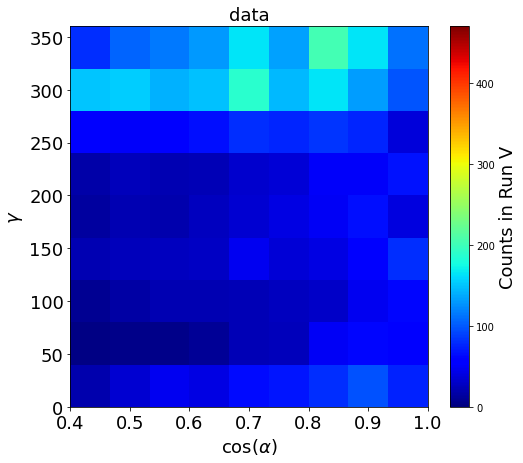

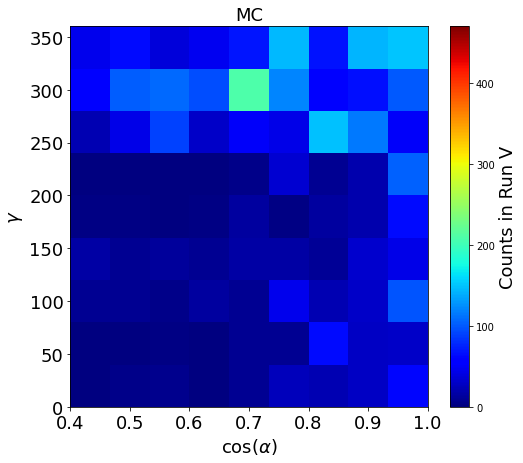

In [277]:
plt.figure(figsize=(8,7))
h2d=plt.hist2d( np.cos(MuonsNoSparks['alpha']),MuonsNoSparks['gamma'],bins=[np.linspace(.4,1,numofsteps),np.linspace(0,360,numofsteps)], cmap=plt.cm.jet,vmin=0,vmax=470)
#h2d=plt.hist2d( np.cos(MuonsNoSparks['alpha']),MuonsNoSparks['beta_rot'],weights=MuonsNoSparks['WeightedPts'],bins=[np.linspace(.4,1,numofsteps),np.linspace(0,360,numofsteps)], cmap=plt.cm.jet,vmin=0,vmax=215)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel(r'$\gamma$',fontsize=18)
plt.xlabel(r'cos($\alpha$)',fontsize=18)
plt.title('data',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('./DataFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()


plt.figure(figsize=(8,7))
MCh2d=plt.hist2d( np.cos(MCmusSpkCut['alpha']),MCmusSpkCut['gamma'],weights=MCwt,bins=[np.linspace(.4,1,numofsteps),np.linspace(0,360,numofsteps)], cmap=plt.cm.jet,vmin=0,vmax=470)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel(r'$\gamma$',fontsize=18)
plt.xlabel(r'cos($\alpha$)',fontsize=18)
plt.title('MC',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('./MCFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()


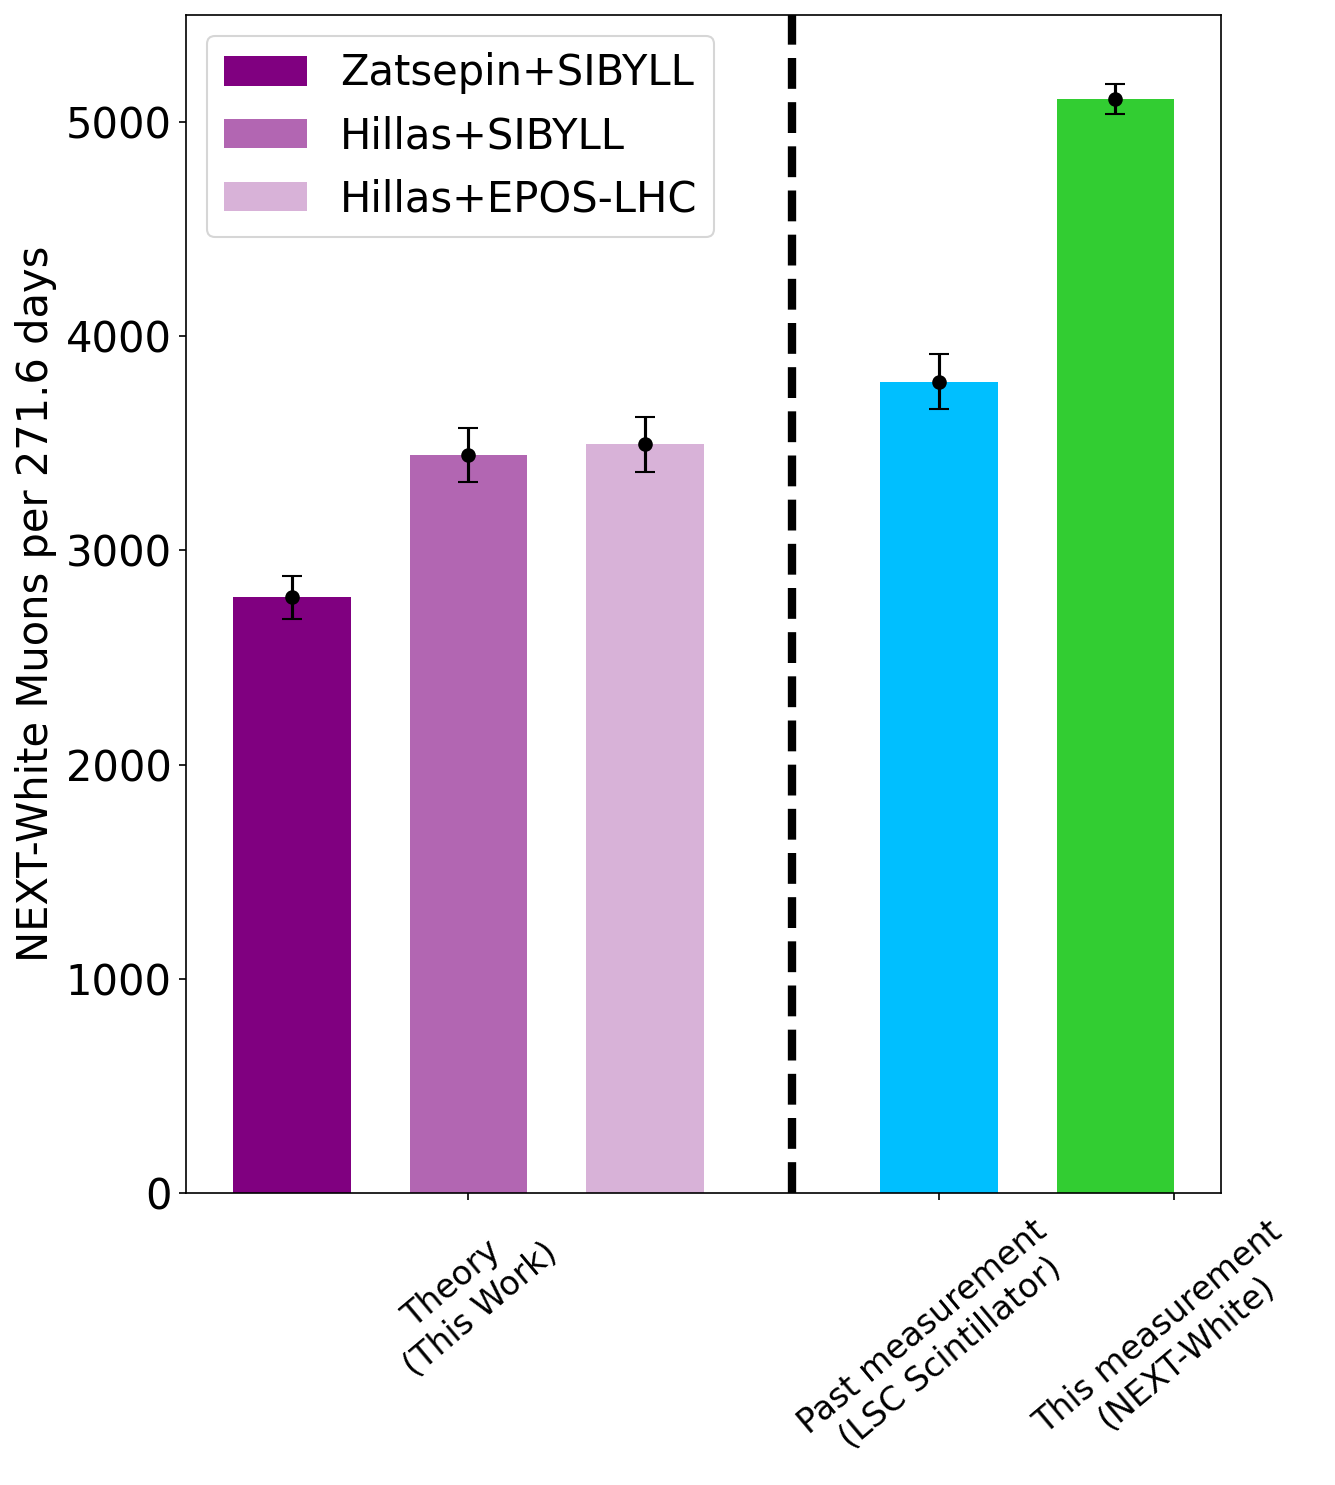

In [278]:
WT1=5.26*(271.6*24*60*60)*(.178*.47) #from paper
err1=.21

WT2=4.77 *(271.6*24*60*60)*(.178*.47) #from Pau
err2=.05




xplace=[1.6,2.2,2.8,3.8,4.4]

Xlableslist=["Theory \n(This Work)", "Past measurement \n(LSC Scintillator)", "This measurement \n(NEXT-White)"]
xplacelist=[2.2,3.8,4.6]



MCwt=MCmusSpkCut['WeightedPts']
MCzt=MCmusSpkCut['WeightedPtsZat']
MCep=MCmusSpkCut['WeightedPtsEpos']
CnMeas=MCmusSpkCut['WeightedPts_MeasFlux']


WT3=np.sum(MCzt)
err3=np.sum(MCzt**2)**.5

WT4=np.sum(MCwt)
err4=np.sum(MCwt**2)**.5

WT5=np.sum(CnMeas)
err5=np.sum(CnMeas**2)**.5


WT6=np.sum(h2d[0])
err6=np.sum(h2d[0])**.5

WT7=np.sum(MCep)
err7=np.sum(MCep**2)**.5


fig = plt.figure(figsize=(9,10),dpi=150)
ax1 = fig.add_subplot(111)
#ax1.bar(xplace[0],height=WT1, width=.4,color="deepskyblue")
#ax1.bar(xplace[1],height=WT2, width=.4,color="deepskyblue")
ax1.bar(xplace[0],height=WT3, width=.4,color="purple",label='Zatsepin+SIBYLL',alpha=1)
plt.errorbar(xplace[0],WT3,color='k',yerr=err3, fmt="o",capsize=5)

ax1.bar(xplace[1],height=WT4, width=.4,color="purple",label='Hillas+SIBYLL',alpha=0.6)
plt.errorbar(xplace[1],WT4,color='k',yerr=err4, fmt="o",capsize=5)

ax1.bar(xplace[2],height=WT7, width=.4,color="purple",label='Hillas+EPOS-LHC',alpha=0.3)
plt.errorbar(xplace[2],WT7,color='k',yerr=err4, fmt="o",capsize=5)

ax1.bar(xplace[3],height=WT5, width=.4,color="deepskyblue")
plt.errorbar(xplace[3],WT5,color='k',yerr=err5, fmt="o",capsize=5)

ax1.bar(xplace[4],height=WT6, width=.4,color="limegreen")
plt.errorbar(xplace[4],WT6,color='k',yerr=err6, fmt="o",capsize=5)

ax1.set_ylabel('NEXT-White Muons per 271.6 days',fontsize=20)
#ax1.text(xplacelist[0:3],Xlableslist[0:3],rotation='verticle')

#plt.errorbar(xplace[0],WT1,color='k',yerr=err1, fmt="o",capsize=5,label='Canfranc Mu Meas')
#plt.errorbar(xplace[1],WT2,color='k',yerr=err2, fmt="o",capsize=5,label='Current Muon Flux Meas from Next')
#plt.errorbar(xplace[2],WT3,color='k',yerr=err3, fmt="o",capsize=5,label='this work')

plt.plot([3.3,3.3],[0,5500],'--',linewidth=4,color='black')
plt.ylim(0,5500)

plt.yticks(fontsize=20)
plt.xticks(xplacelist,Xlableslist,fontsize=16,rotation=40)
plt.tight_layout()
plt.legend(fontsize=20)

plt.yticks(fontsize=20) 
#plt.semilogy()
#plt.tight_layout()

plt.savefig("./diffflux.png",dpi=250,bbox_inches='tight')

In [262]:
intMCwt=np.sum((MCmusSpkCut['WeightedPts']+MCmusSpkCut['WeightedPtsZat']+MCmusSpkCut['WeightedPtsEpos'])/3)
intST5=np.sum(MCmusSpkCut['WeightedPts']**2)
intSB5=np.sum(MCmusSpkCut['WeightedPtsZat']**2)
intSE5=np.sum(MCmusSpkCut['WeightedPtsEpos']**2)


interr5=np.sum(((intST5+intSB5+intSE5)/3)**.5)

In [263]:
print('sim',intMCwt,'plus/min',interr5)
print('meas',WT5,'plus/min',err5)
print('data',WT6,'plus/min',err6)

sim 3241.0645061051973 plus/min 119.28787620620953
meas 3782.0479123377313 plus/min 129.01643262229305
data 5108.0 plus/min 71.47027354082255


# Everything below this line is suspect

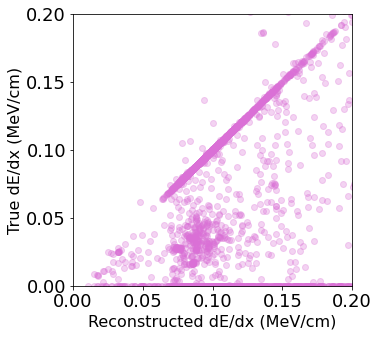

In [264]:
fig = plt.figure(figsize=(5,5))
plt.scatter(MCmus.dEdx*10,MCmus["MCdEdx"]*10,alpha=.3,color='orchid')
plt.xlabel("Reconstructed dE/dx (MeV/cm)",fontsize=16)
plt.ylabel("True dE/dx (MeV/cm)",fontsize=16)
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.locator_params(nbins=4)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.savefig('TrueVSrecodEdx.png',dpi=250,bbox_inches='tight')

KeyError: 'beta_rot'

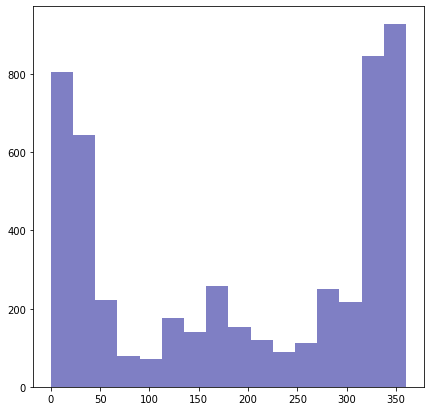

In [265]:
numofsteps=17

factorbeta=np.sum(h[0])/MCmusSpkCut['WeightedPts'].sum()

plt.figure(figsize=(7,7))
#factorbeta=2.01
plt.hist(np.rad2deg(MCmusSpkCut['beta']),weights=MCmusSpkCut['WeightedPts']*factorbeta,bins=np.linspace(0,360,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(MuonsFromData['beta_rot'],bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper right")
plt.savefig('betahist_factor.png',dpi=250,bbox_inches='tight')
plt.show()

#factoralpha=2.01
plt.figure(figsize=(7,7))
Mh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts']*factorbeta,bins=np.linspace(.4,1,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
h=plt.hist(np.cos(MuonsFromData['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
plt.savefig('alphahist_factor.png',dpi=250,bbox_inches='tight')
plt.show()

In [ ]:

stpsize=30

binsa=np.linspace(0,385,stpsize)
bin_centersa = binsa[:-1] + np.diff(binsa) / 2
bin_edgesa=binsa[:-1] 
binsz=np.linspace(0,1.08,stpsize)
bin_centersz = binsz[:-1] + np.diff(binsz) / 2
bin_edgesz=binsz[:-1] 

plt.figure(figsize=(8,7))
plt.hist2d( np.cos(MuonsNoSparks['alpha']),MuonsNoSparks['beta_rot'],bins=[bin_edgesz,bin_edgesa], cmap=plt.cm.jet)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel('azimuth',fontsize=18)
plt.xlabel('cos(zenith)',fontsize=18)
plt.title('data',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('DataFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,7))
plt.hist2d( np.cos(MCmusSpkCut['alpha']),np.rad2deg(MCmusSpkCut['beta']),weights=MCmusSpkCut['WeightedPts']*factorbeta,bins=[bin_edgesz,bin_edgesa], cmap=plt.cm.jet)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel('azimuth',fontsize=18)
plt.xlabel('cos(zenith)',fontsize=18)
plt.title('MC',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
plt.savefig('MCFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()

In [ ]:
l=49 #cm
d=35.6 #cm
fiducial_area=l*d

In [ ]:
def onlook_area(cosalpha):
    l=49 #cm
    d=35.6 #cm
    zeta=np.pi/2-np.arccos(cosalpha)
    A=d*l*np.sin(zeta)+np.pi*(d/2)**2*np.cos(zeta)
    return A

In [ ]:
plt.figure(figsize=(5,5),dpi=200)
totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m
ster=np.diff(bs)[0]*np.diff(cosas)[0]
tau=271.6*24*60*60
im=plt.pcolormesh(cosas,bs,np.transpose(totalflux*ster)*onlook_area(cosas)*tau,cmap='inferno',shading='auto',vmin=0,vmax=60)
ax.set_title("Integrated, MCeQ+Proposal")

plt.xlabel(r"cos($\alpha$)")
plt.ylabel(r"$\beta$")
plt.xlim(0.4,1)
plt.title("Integrated Flux")
cbar=plt.colorbar()
cbar.set_label('Flux for RunV',fontsize=16)
plt.savefig("/Users/rogerslc/Documents/MuFluxPred/IntegratedFlux.png",dpi=250,bbox_inches='tight')

In [ ]:

cos_centersa=cosas[:-1] + np.diff(cosas) / 2



In [ ]:
plt.figure(figsize=(5,5),dpi=150)
plt.plot(cosas,[sum(t) for t in totalflux])
plt.xlabel(r"cos($\alpha$)")
plt.ylim(0,5e-6)


In [ ]:

plt.figure(figsize=(5,5),dpi=150)

plt.ylim(0,1e-5)
plt.plot(bs,sum(totalflux))
plt.xlabel(r"$\beta$")

In [ ]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,bs,np.transpose(survivalfractions[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=1)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Survival Fration',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[0,0].set_ylabel(r"$\beta$",fontsize=12)

In [ ]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,bs,np.transpose(FluxMeshes[iax+startn]),cmap='inferno',shading='auto',vmin=0,vmax=1e-7)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\beta$",fontsize=12)
axes[0,0].set_ylabel(r"$\beta$",fontsize=12)

plt.savefig('/Users/rogerslc/Documents/MuFluxPred/MCeqFluxes.png',dpi=250,bbox_inches='tight')
plt.show()

In [ ]:
cosas

In [ ]:
cosa_mesh, b_mesh=np.meshgrid(cosas,bs)

In [ ]:
bs

In [ ]:
a_s=np.arccos(cosas-0.001)

In [ ]:

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),constrained_layout=True,figsize=(5,5),dpi=200)
fig.patch.set_facecolor('white')
levels=np.linspace(0,3.3e-7,65)
im=ax.contourf(bs,np.arccos(cosas-0.001)*180/3.14, totalflux,cmap='turbo',levels=levels)
ax.set_rlim(0,60)
ax.set_rticks([0,15,30,45,60])
#plt.savefig("Radars/"+str(ei).zfill(2)+".png",dpi=200)
cb =plt.colorbar(im, shrink=0.7,ticks=np.arange(0,3.5e-7,5e-8))
#cb = fig.colorbar(im, shrink=0.7)
cb.set_label("Muon Flux [10$^{-4}$m$^{2}$s$^{-1}$sr$^{-1}$]")
ax.set_thetagrids([0,90,180,270],['E','N','W','S'])
ax.set(facecolor = "lightgrey",alpha=0.2)
plt.savefig("/Users/rogerslc/Documents/MuFluxPred/PolarFluxes.png",dpi=250,bbox_inches='tight')
plt.show()

In [266]:
numofsteps=17

plt.figure(figsize=(7,7))
Mh=plt.hist(MCmusSpkCut['beta_rot'],weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(0,360,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
Polh=plt.hist(MCmusSpkCut['beta_rot'],weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(0,360,numofsteps),color='green',alpha=0.5,label='Measured MuFlux')
h=plt.hist(MuonsNoSparks['beta_rot'],bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper right")
#plt.savefig('betahist.png',dpi=250,bbox_inches='tight')
plt.show()

factorbeta=np.mean(h[0]/Mh[0])
factorbetaM=np.mean(h[0]/Polh[0])

plt.figure(figsize=(7,7))
Mh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(.4,1,numofsteps),color='DarkBlue',alpha=0.5,label='MC')
Polh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(.4,1,numofsteps),color='green',alpha=0.5,label='Measured MuFlux')
h=plt.hist(np.cos(MuonsNoSparks['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data')
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
#plt.savefig('alphahist.png',dpi=250,bbox_inches='tight')
plt.show()

factoralpha=np.mean(h[0]/Mh[0])
factoralphaM=np.mean(h[0]/Polh[0])
print(factorbeta,factorbetaM,factoralpha,factoralphaM)

KeyError: 'beta_rot'

<Figure size 504x504 with 0 Axes>